<a href="https://colab.research.google.com/github/chaitragopalappa/MIE590-690D/blob/main/3b_Code_MLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for classification problems

# Exercise
Below is a code for a classification problem. It has two versions.
- A wrong_model that uses 1 node in ouput, i.e., the output is the 'class'
- A correct_model where the output layer has size equal to number of classes- the output is a probability distribution.

Observe the outputs from each code in the summarize graphs. Why does the correct_model (i.e., why does having a probability distribution as output) have a better performance?

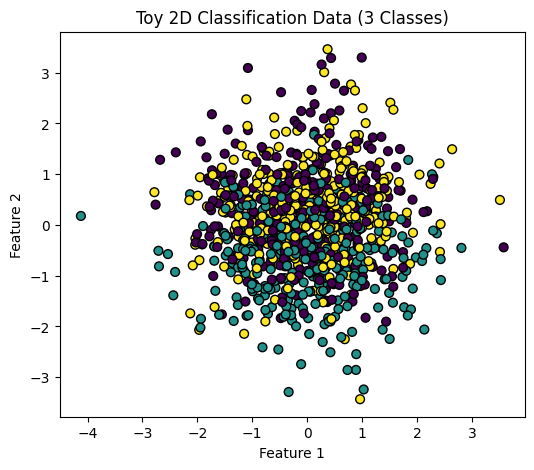

In [1]:
#Generated using ChatGPT
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# ----- Generate toy data -----
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3,
                           n_informative=10, n_redundant=0, random_state=42)

# 2D dataset (easier to visualize)
#X, y = make_classification(n_samples=1000, n_features=2, n_classes=3,
#                           n_informative=2, n_redundant=0, random_state=42)

X = StandardScaler().fit_transform(X) #Standardization (z-score scaling: mean=0, std=1)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="viridis", edgecolor="k", s=40)
plt.title("Toy 2D Classification Data (3 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

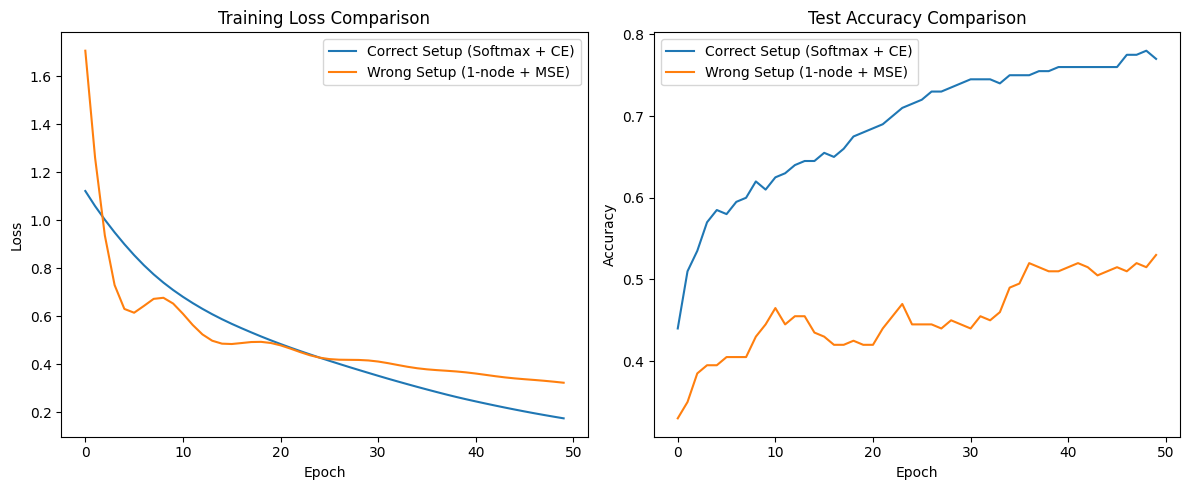

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)   # keep float for WrongMLP
y_test  = torch.tensor(y_test, dtype=torch.float32)

input_dim = X.shape[1]
output_dim = len(set(y))  # number of classes


# ----- Correct Model -----
class CorrectMLP(nn.Module):
    def __init__(self):
        super(CorrectMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim) #Output has nodes equal to number of classes  = in ML language they are called logits (they are raw outputs which do not sum to 1 or have value 0 to 1).(In math logits are log odds of a probability=log(p/(1-p)))
                                      #OUr interest is a probability distribution, which can be obtained by passing outputs through a softmax function (The connection to logits comes from this)
        )
    def forward(self, x): #Softmax is typically added in the output layer to generate a probability.
                          #For classification  problems , instead of MSE loss, we use Cross-Entropy Loss which measures the dissimilarity between two distributions; H(p,q)=- \sum p log (q);;
                          #IN pytorch Cross Entropy loss is set as H(p,q)=- \sum p log (softmax(q)); i.e., softmax is coded into the loss function
        return self.fc(x)

# ----- Wrong Model -----
class WrongMLP(nn.Module):
    def __init__(self):
        super(WrongMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # single node
        )
    def forward(self, x):
        return self.fc(x)


# ----- Training function -----
def train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=50, correct=True):
    losses, accs = [], []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)

        if correct:
            loss = criterion(outputs, y_train.long())#inputs to Entropy loss need to be int64
        else:
            outputs = outputs.squeeze()
            loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if correct:
                preds = model(X_test).argmax(dim=1)
                acc = (preds == y_test.long()).float().mean().item()
            else:
                preds = model(X_test).squeeze()
                preds = torch.round(preds).clamp(0, output_dim-1).int()
                acc = (preds == y_test.int()).float().mean().item()

        losses.append(loss.item())
        accs.append(acc)

    return losses, accs


# ----- Train both models -----
correct_model = CorrectMLP()
correct_losses, correct_accs = train_model(
    correct_model,
    nn.CrossEntropyLoss(),
    optim.Adam(correct_model.parameters(), lr=0.01),
    X_train, y_train, X_test, y_test,
    epochs=50, correct=True
)

wrong_model = WrongMLP()
wrong_losses, wrong_accs = train_model(
    wrong_model,
    nn.MSELoss(),
    optim.Adam(wrong_model.parameters(), lr=0.01),
    X_train, y_train, X_test, y_test,
    epochs=50, correct=False
)


# ----- Plot both on same figures -----
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(correct_losses, label="Correct Setup (Softmax + CE)")
plt.plot(wrong_losses, label="Wrong Setup (1-node + MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(correct_accs, label="Correct Setup (Softmax + CE)")
plt.plot(wrong_accs, label="Wrong Setup (1-node + MSE)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()
